# Deep Learning for Conversational AI

# Importing libraries

In [ ]:
# linear algebra
import numpy as np 
# data processing, CSV file I/O 
import pandas as pd 

# deep learning, text preprocessing
import tensorflow as tf
print("tensorflow version: " + tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# data visualization
import matplotlib.pyplot as plt

import pickle
import json
import warnings
warnings.filterwarnings('ignore')

tensorflow version: 2.4.1


# Text preprocessing

# Dataset
Built-in intents (Apple’s SiriKit, Amazon’s Alexa, Microsoft’s Luis, Google’s API.ai, and Snips.ai) on a selection of various intents. This benchmark was performed in December 2016. Its results are described in length in the following post. [Dataset](https://github.com/sonos/nlu-benchmark)

In [ ]:
df = pd.read_csv("snip.csv")
df.head()

,Unnamed: 0,text,intent
0,0,"add Stani, stani Ibar vodo songs in my playlis...",AddToPlaylist
1,1,add this album to my Blues playlist,AddToPlaylist
2,2,Add the tune to the Rage Radio playlist.,AddToPlaylist
3,3,Add WC Handy to my Sax and the City playlist,AddToPlaylist
4,4,Add BSlade to women of k-pop playlist,AddToPlaylist


In [ ]:
print(df['intent'].unique())

num_classes = df['intent'].nunique()
print(num_classes)

['AddToPlaylist' 'PlayMusic' 'BookRestaurant' 'GetWeather' 'RateBook'
 'SearchCreativeWork' 'SearchScreeningEvent']
7


In [ ]:
len(df)

2100

In [ ]:
# convert the type of intent columns to 'category'
df['intent'] = df['intent'].astype('category')

# create a new column contaning numeric values of intent columns
df['intent_cat'] = df['intent'].cat.codes
df.head()

,Unnamed: 0,text,intent,intent_cat
0,0,"add Stani, stani Ibar vodo songs in my playlis...",AddToPlaylist,0
1,1,add this album to my Blues playlist,AddToPlaylist,0
2,2,Add the tune to the Rage Radio playlist.,AddToPlaylist,0
3,3,Add WC Handy to my Sax and the City playlist,AddToPlaylist,0
4,4,Add BSlade to women of k-pop playlist,AddToPlaylist,0


In [ ]:
# random the sample of dataset with 100% 
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Unnamed: 0,text,intent,intent_cat
0,1582,Please help me find the Selections from the Ar...,SearchCreativeWork,5
1,512,Play the latest Peter Green.,PlayMusic,3
2,1175,What will the weather be in Berville AK on Feb...,GetWeather,2
3,593,Play music from 1972,PlayMusic,3
4,1154,I need the weather for 7/13/2036 in Gwynedd Va...,GetWeather,2


In [ ]:
# create labels and sentences
labels = df['intent_cat'].values
sentences = df['text'].values

print(labels[:1])
print(sentences[:1])

[5]
['Please help me find the Selections from the Arista Years video game.']


In [ ]:
# find the maximum number of words in sentences
max_sequence_len = max([len(x) for x in sentences])
print(max_sequence_len)

135


In [ ]:
# define processing strategies
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# tokenize text into a list of tokens
# each integer being the index of a token in a dictionary
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)

print(word_index)
print("vocab_size:", vocab_size)

{'<OOV>': 1, 'the': 2, 'to': 3, 'a': 4, 'in': 5, 'for': 6, 'of': 7, 'at': 8, 'i': 9, 'book': 10, 'me': 11, 'add': 12, 'playlist': 13, 'my': 14, 'is': 15, 'play': 16, 'find': 17, 'from': 18, '6': 19, 'give': 20, 'want': 21, 'please': 22, 'this': 23, 'movie': 24, 'what': 25, 'out': 26, 'weather': 27, 'be': 28, 'will': 29, 'on': 30, 'and': 31, 'by': 32, 'rate': 33, 'can': 34, 'it': 35, 'stars': 36, 'current': 37, 'restaurant': 38, 'you': 39, 'points': 40, 'reservation': 41, 'album': 42, 'music': 43, 'playing': 44, 'show': 45, 'forecast': 46, 'need': 47, 'schedule': 48, 'movies': 49, 'table': 50, 'song': 51, 'people': 52, 'search': 53, 'one': 54, 'now': 55, 'theatres': 56, 'some': 57, 'see': 58, 'house': 59, 'get': 60, 'track': 61, 'novel': 62, 'work': 63, 'look': 64, 'are': 65, 'two': 66, 'four': 67, '2': 68, 'an': 69, '5': 70, 'times': 71, 'when': 72, 'like': 73, '1': 74, 'that': 75, 'up': 76, '4': 77, 'hear': 78, 'showing': 79, 'artist': 80, '3': 81, 'animated': 82, 'tune': 83, 'called'

In [ ]:
# convert a text to a sequence of words 
sequences = tokenizer.texts_to_sequences(sentences)
# pad sequences to the same length
padded = pad_sequences(sequences, maxlen=max_sequence_len, padding=padding_type, truncating=trunc_type)

print(sequences[0])
print(padded[0])

[22, 123, 11, 17, 2, 1092, 18, 2, 1093, 202, 171, 88]
[  22  123   11   17    2 1092   18    2 1093  202  171   88    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [ ]:
# convert the tokenizer vocabulary to a JSON file
with open('vocab.json' , 'w', encoding='utf8') as file:
  json.dump(tokenizer.word_index, file, ensure_ascii=False)

# Creating a model

In [ ]:
# potion 10% of the dataset for testing 
training_size = len(df)
test_portion=.1

# split the dataset into training and test data
split = int(test_portion * training_size)
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

print("test_sequences:", len(test_sequences))
print("training_sequences:", len(training_sequences))

test_sequences: 210
training_sequences: 1890


In [ ]:
# create a Bi-LSTM model
embedding_dim = 50

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_sequence_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
    tf.keras.layers.Dense(7, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 135, 50)           173150    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 48)                14400     
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 343       
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 56        
Total params: 187,949
Trainable params: 187,949
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# create a custom callback function
class CustomCallbacks(tf.keras.callbacks.Callback):
  
  # create an early stopping function 
  def on_epoch_end(self, epoch, logs={}):
    DESIRED_ACCURACY = 0.99
    if(logs.get('accuracy')>DESIRED_ACCURACY):
        print("\n 99% accuracy reached")
        self.model.stop_training = True

callbacks = CustomCallbacks()

# Training a model 

In [ ]:
# train a model
num_epochs = 20

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    callbacks=[callbacks],
                    validation_data=(testing_padded, testing_labels), 
                    verbose=1)

print("Training Complete")

Epoch 1/20
60/60 [==============================] - 4s 31ms/step - loss: 1.9094 - accuracy: 0.3121 - val_loss: 1.6262 - val_accuracy: 0.5286
Epoch 2/20
60/60 [==============================] - 1s 13ms/step - loss: 1.3923 - accuracy: 0.6089 - val_loss: 0.8243 - val_accuracy: 0.8095
Epoch 3/20
60/60 [==============================] - 1s 13ms/step - loss: 0.7213 - accuracy: 0.8050 - val_loss: 0.5313 - val_accuracy: 0.8524
Epoch 4/20
60/60 [==============================] - 1s 13ms/step - loss: 0.4046 - accuracy: 0.8881 - val_loss: 0.4035 - val_accuracy: 0.9333
Epoch 5/20
60/60 [==============================] - 1s 13ms/step - loss: 0.2545 - accuracy: 0.9783 - val_loss: 0.3168 - val_accuracy: 0.9238
Epoch 6/20
60/60 [==============================] - 1s 13ms/step - loss: 0.1415 - accuracy: 0.9928 - val_loss: 0.2653 - val_accuracy: 0.9429

 99% accuracy reached
Training Complete


# Performence visualization

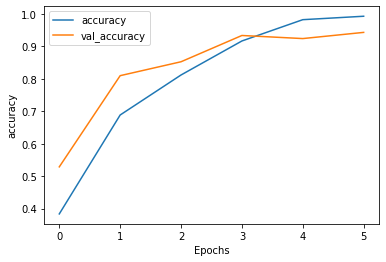

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')

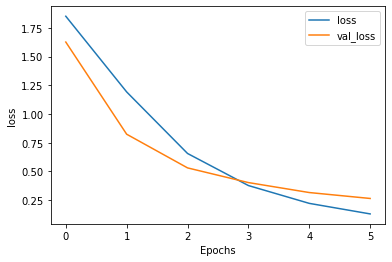

In [ ]:
plot_graphs(history, 'loss')

# Convert the Keras ( .h5 ) model to a TensorFlow Lite model ( .tflite )

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('intent_classification.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpxwaqy4wi/assets


INFO:tensorflow:Assets written to: /tmp/tmpxwaqy4wi/assets
